In [1]:
import sys
import pandas as pd
import proplot as plot
import cartopy.crs as ccrs
from datetime import datetime, timedelta

In [2]:
sys.path.append('../XZ_maps')
from xin_cartopy import load_province
provinces = load_province()

In [4]:
# set paras
data_dir = './data/'
save_dir = './figures/'
savename = 'CLDN_ENGLN_20200901.png'

In [6]:
f_cldn = 'CLDN_20200901.csv'
f_engln = 'ENGLN_20200901_nomerge.csv'

extend = [118, 120, 31.5, 33.5]
lon_d = 0.5; lat_d = 0.5

start_time = ['2020-09-01 02:00:00',
              '2020-09-01 03:00:00',
              '2020-09-01 04:00:00',
              '2020-09-01 05:00:00',
              '2020-09-10 06:00:00']

end_time = start_time[1:] + ['2020-09-01 07:00:00']

In [7]:
scatter_colors = ['blue4',
                  'blue7',
                  'red2',
                  'red4',
                  'red8']

In [14]:
def subset(df, kind, data='CLDN'):
    if kind == 'CG':
            return df[(df['type'] == 0) | (df['type'] == 40)]
    elif kind == 'IC':
        return df[df['type'] == 1]

def plot_scatter(ax, df, scatter_color, start_time, end_time):
    start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    end_time = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')

    label = start_time.strftime('%H:%M') + ' ~ ' + end_time.strftime('%H:%M (UTC)')

    m = ax.scatter(df['longitude'],
                   df['latitude'],
                   facecolors='none',
                   edgecolors=scatter_color,
                   transform=ccrs.PlateCarree(),
                   s=5,
                   label=label,
                   )

    # add arrows
    arrow_properties = dict(
        facecolor='gray7',
        edgecolor='gray7',
        width=0.5,
        headwidth=4, shrink=0.1)

    ax.annotate('Ozonesonde', xy=(118.9, 31.9),
                xytext=(119.2, 31.7),
                arrowprops=arrow_properties,
                color='gray7'
                )

#     ax.annotate('MAX-DOAS', xy=(118.72, 32.21),
#                 xytext=(118.1, 31.9),
#                 arrowprops=arrow_properties,
#                 color='gray7'
#                 )

    return m

In [16]:
def read_data(data_dir, f_cldn, f_engln):
    # read CLDN data
#     df_cldn = pd.read_excel(data_dir+f_cldn, encoding='ISO-8859-1')
    df_cldn = pd.read_csv(data_dir+f_cldn)
    # convert to UTC
    df_cldn['date'] = pd.to_datetime(df_cldn['timestamp'])# - timedelta(hours=8)
    # set datetime as index
    df_cldn = df_cldn.set_index(['date'])

    # read ENGLN data
    df_engln = pd.read_csv(data_dir+f_engln, delimiter=',')
    df_engln['date'] = pd.to_datetime(df_engln['timestamp'])
    df_engln = df_engln.set_index(['date'])

    return df_cldn, df_engln

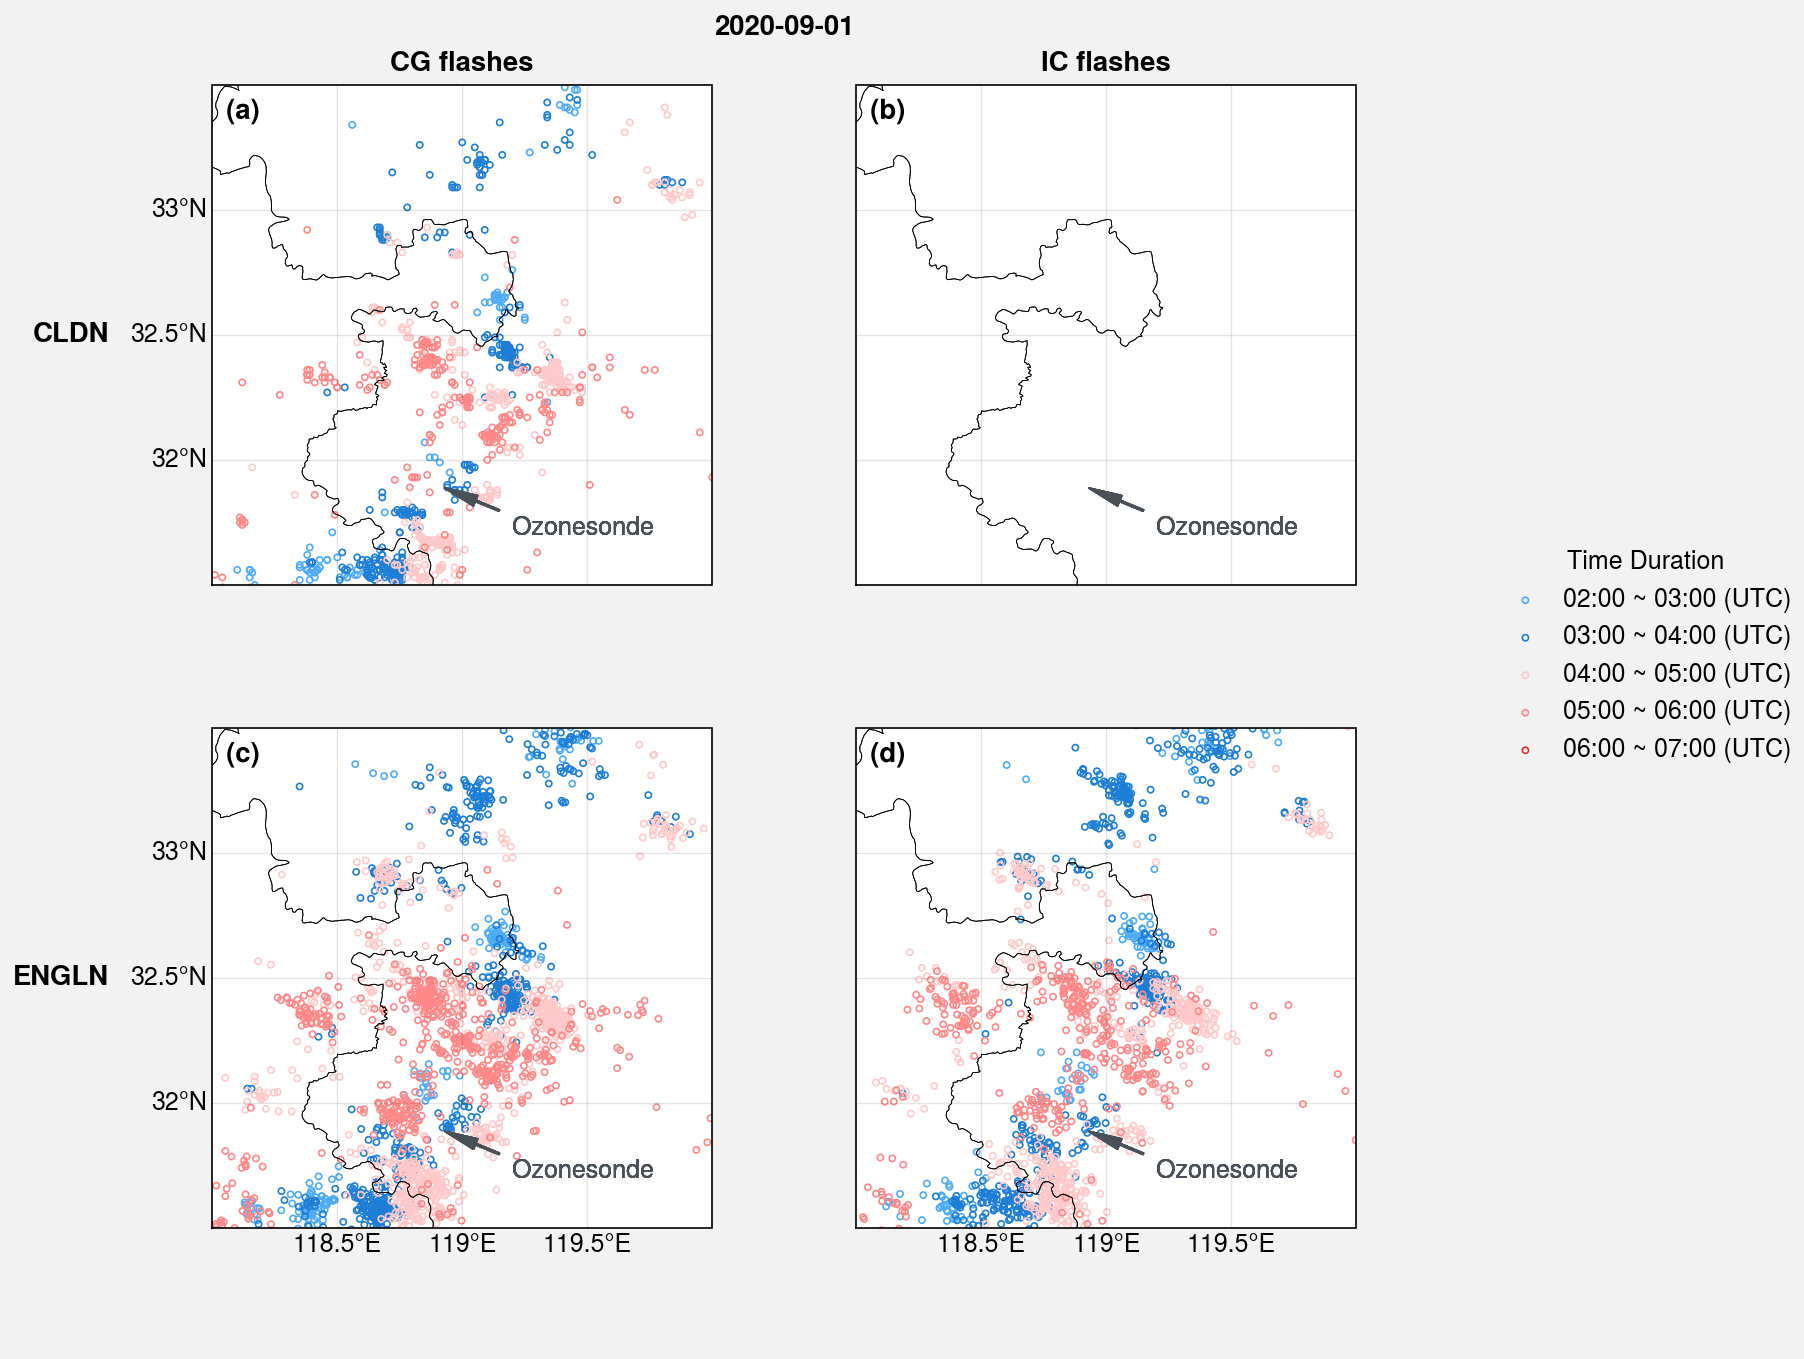

In [17]:
# set plot
f, axs = plot.subplots(ncols=2,
                       nrows=2,
                       proj='pcarree',
                       share=0
                       )

axs.format(collabels=['CG flashes', 'IC flashes'],
           rowlabels=['CLDN', 'ENGLN'],
           abc=True, abcloc='ul', abcstyle='(a)',
           # labels=True,
           lonlines=lon_d,
           latlines=lat_d,
           lonlim=(extend[0], extend[1]),
           latlim=(extend[2], extend[3]),
           gridlinewidth=0.5,
           gridcolor='k',
           dms=False,
           )

# plot the map
axs.add_feature(provinces, edgecolor='k', linewidth=.3)

# read data
df_cldn, df_engln = read_data(data_dir, f_cldn, f_engln)

# plot ENGLN data
# plot CLDN and ENGLN data
handles = []
for idx, st in enumerate(start_time):
    cg_cldn = subset(df_cldn.loc[st:end_time[idx]], 'CG')
    ic_cldn = subset(df_cldn.loc[st:end_time[idx]], 'IC')
    cg_engln = subset(df_engln.loc[st:end_time[idx]], 'CG', 'ENGLN')
    ic_engln = subset(df_engln.loc[st:end_time[idx]], 'IC', 'ENGLN')

    plot_scatter(axs[0], cg_cldn, scatter_colors[idx],
                 start_time[idx], end_time[idx])
    plot_scatter(axs[1], ic_cldn, scatter_colors[idx],
                 start_time[idx], end_time[idx])
    plot_scatter(axs[2], cg_engln, scatter_colors[idx],
                 start_time[idx], end_time[idx])
    s = plot_scatter(axs[3], ic_engln, scatter_colors[idx],
                     start_time[idx], end_time[idx])
    handles.append(s)

f.legend(handles,
         ncols=1,
         frame=False,
         title='Time Duration')

# share labels
axs[:, 0].format(latlabels=True)
axs[-1, :].format(lonlabels=True)
axs.format(suptitle='2020-09-01')

f.savefig(save_dir+savename)